**Introdução**

A Lei Seca brasileira (Lei 11.705/08) sancionada em junho de 2008, foi criada com o objetivo de combater a combinação de álcool e direção e consequentemente reduzir os acidentes e as mortes no trânsito das cidades brasileiras. Estabeleceu-se a tolerância zero para o nível de álcool no sangue dos condutores de veículos, permitiu-se a aplicação de testes de alcoolemia, como o bafômetro, e imputou-se penalidades mais severas, incluindo-se multas, suspensão da habilitação e, em casos graves, a criminalização.

Diante desse cenário, este trabalho tem como hipótese entender se a implementação da Lei Seca no Brasil impactou positivamente a ocorrência de acidentes envolvendo álcool.


**Descrição do Dataset**

Para a realização deste trabalho, foi utilizado um dataset disponível no Kaggle, denominado "Brazil Traffic Incidents", que fornece informações sobre acidentes de veículos no Brasil entre os anos de 2007 à 2023. Este está organizado em 18 tabelas no formato CSV, sendo 17 delas dedicadas a dados sobre os acidentes e uma sobre dados dos radares.

Originalmente cada tabela contém entre 26 a 30 atributos, oferecendo uma visão abrangente dos incidentes, incluindo a localização das vias, detalhes dos acidentes, causas, vítimas, entre outros.

No entanto, para este estudo, foram utilizadas apenas as informações das tabelas até o ano de 2022, visto que os dados de 2023 ainda não estavam completos e os dados dos radares foram descartados. Além disso, foram selecionados somente um atributos e acrescentado mais dois novos, que se refere ao ano do acidente e se o acidente envolveu consumo de álcool, conforme descrito abaixo:

**Dados:**
* Unidade Federativa: : Unidade Federativa que aonde ocorreu o acidente;
* Ano: Ano que ocorreu o acidente;
* Acidente com Álcool: Identifica se o acidente envolveu álcool (1 para sim e 0 para não).


**Carga de Dados**

Para realizar a importação dos dados, o dataset foi armazenado no GitHub e posteriormente, as tabelas referentes aos dados dos acidentes, foram concatenadas em um único DataFrame. Em seguida, os nomes das colunas foram modificados para aumentar a legibilidade, foi acrescida a coluna "Ano" e  os campos nulos ou faltantes, que estavam definidos como ‘(null)’, tiveram seus valores convertidos para NaN (Not a Number), permitindo o tratamento adequado posteriormente.

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação de pacotes
import pandas as pd
import numpy as np

#Tratamento de Missings
import missingno as ms

#Construção de gráficos
import matplotlib.pyplot as plt

#Exibição de dados
#from IPython.display import display

# Importação da função para dividir o dataset em conjuntos de treino e teste
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

# Importação de métricas de avaliação MSE
from sklearn.metrics import mean_squared_error

# Importação dos algoritmos de regressão e outros modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Preprocessamento
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Lista dos anos
anos = list(range(2007, 2023))

# Lista para armazenar os DataFrames
dfs = []

# Colunas a serem lidas
colunas = ['uf', 'causa_acidente']

# Caminho base dos arquivos no GitHub
base_url = 'https://github.com/preussagnes/mvp-machine-learning-e-analytics/raw/main/DataSet/Dados_PRF_'

# Criação da url do arquivo conforme o ano
for ano in anos:

    url = f"{base_url}{ano}.csv"

    # Leitura do dataset, mantendo apenas as colunas desejadas e tratando NaNs
    df = pd.read_csv(url, usecols=colunas, encoding='latin1', delimiter=';', na_values=['(null)'])

    # Renomeação das colunas para maior legibilidade
    df.rename(columns={ 'uf': 'Unidade Federativa', 'causa_acidente': 'Causa do Acidente'}, inplace=True)

    # Adicionamento da coluna de ano
    df['Ano'] = ano

    # Adicionamento do DataFrame à lista
    dfs.append(df)

# Concatenação em um único DataFrame
df = pd.concat(dfs, ignore_index=True)

# Verificcação dos primeiros registros
print(df.head())
print("Valores nulos por coluna:")
print(df.isnull().sum(),'\n')


  Unidade Federativa            Causa do Acidente   Ano
0                 MG             Falta de atenção  2007
1                 MG             Falta de atenção  2007
2                 MG                       Outras  2007
3                 MA             Animais na Pista  2007
4                 CE  Defeito mecânico em veículo  2007
Valores nulos por coluna:
Unidade Federativa    12
Causa do Acidente      2
Ano                    0
dtype: int64 



**Preparação dos dados**

Após a concatenação em um único DataFrame foram realizadas algumas alterações no dataset:

* As linhas contendo valores nulos foram removidas, para garantir a consistência do conjunto de dados;
* A variável categórica, "Unidade Federativa", foi convertida em valor numérico, facilitando sua interpretação pelos modelos;
* Foi adicionado uma nova coluna, "Acidente com Álcool";
* Foi descartado a coluna "Causa do Acidente".

Visando a análise temporal e regional, os dados foram agrupados por ano e unidade federativa, somando os acidentes relacionados ao consumo de álcool em cada grupo. Logo após, as variáveis independentes (x) e a variável dependente (y) foram definidas e separadas em conjuntos de treino e teste (80% e 20%, respectivamente). Por fim, foi criada uma configuração para validação cruzada com 10 partições (folds), permitindo uma avaliação robusta dos modelos com diferentes divisões dos dados.

In [ ]:
#Exclusão das linhas que contenham algum valor missing (NaN)
df=df.dropna(how='any')

# Converção da variáveis categóricas em variáveis numéricas
le_uf = LabelEncoder()
df['Unidade Federativa'] = le_uf.fit_transform(df['Unidade Federativa'])

#Criação da coluna 'Acidente com Álcool' para representar se o acidente envolve álcool (1) e 0 caso contrário
df['Acidente com Álcool'] = df['Causa do Acidente'].str.contains('álcool', case=False, na=False).astype(int)

#Exclusão da Coluna 'Causa do Acidente'
df.drop(columns=['Causa do Acidente'], inplace=True)

# CRiação da variável referente a quantidade de acidentes com álcool por ano e estado
df_grouped = df.groupby(['Ano', 'Unidade Federativa'])['Acidente com Álcool'].sum().reset_index(name='quantidade_acidentes_alcool')

# Definindo x (atributos) e y (target)
x = df_grouped[['Ano', 'Unidade Federativa']]  # variáveis independentes
y = df_grouped['quantidade_acidentes_alcool']  # variável dependente

#Separação entre treino (80%) e teste (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# Criação dos folds para a validação cruzada
num_particoes = 10  # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7)  # faz o particionamento em 10 folds


**Modelagem e Treinamento**

Para este trabalho, optou-se por utilizar modelos de aprendizado de máquina para problemas de regressão, possibilitando não apenas entender tendências históricas, mas também realizar previsões futuras referentes a quantidade de acidentes envolvendo álcool. Sendo assim, foram treinados os modelos de Regressão Linear (LR), Regressão Ridge, Regressão Lasso, Regressor K-Nearest Neighbors (KNN), Regressor de Árvore de Decisão (CART) e Regressor de Vetores de Suporte (SVM).

Como métricas de avaliação, foram utilizados o Erro Quadrático Médio (MSE) e a Raiz do Erro Quadrático Médio (RMSE), ambas adequadas para problemas de regressão, pois penalizam erros maiores com mais intensidade e são úteis para avaliar a performance do modelo na previsão de valores contínuos. Além disso, o desvio padrão dos resultados da validação cruzada foi calculado, complementando a avaliação ao indicar a estabilidade do modelo em diferentes folds e auxiliando na identificação de possíveis tendências de overfitting ou underfitting.

LR: MSE 52197.95 (25764.31) - RMSE 228.47
Ridge: MSE 52197.89 (25764.43) - RMSE 228.47
Lasso: MSE 52188.88 (25767.97) - RMSE 228.45
KNN: MSE 42361.72 (14484.74) - RMSE 205.82
CART: MSE 4338.53 (4528.60) - RMSE 65.87
SVM: MSE 62837.62 (33828.39) - RMSE 250.67


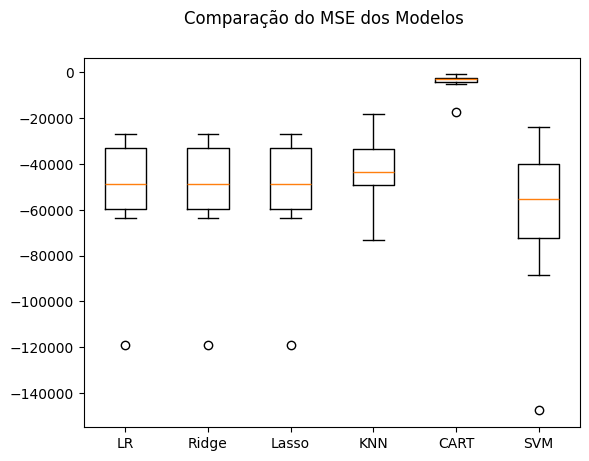

In [ ]:
# Definindo uma seed global
np.random.seed(7)

# Lista de modelos para comparar
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliação de cada modelo usando validação cruzada
results = []
names = []

for name, model in models:
    # Validação cruzada e cálculo do MSE negativo (quanto menor, melhor)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

    # Armazenamento dos resultados
    results.append(cv_results)
    names.append(name)

    # Impressão dos resultados (MSE e RMSE)
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    print(msg)

# Comparação visual dos resultados com um boxplot
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


Com base nos valores de MSE, RMSE e desvio padrão, observou-se que o modelo CART apresentou o melhor desempenho geral. No entanto, a alta variabilidade nos resultados sugere uma possível tendência ao overfitting, já que o modelo parece se ajustar excessivamente a alguns folds. Os modelos de Regressão Linear, Ridge e Lasso apresentaram desempenhos semelhantes, com altos valores de MSE e RMSE, o que sugere que a regularização imposta por esses métodos pode ter levado a underfitting, não capturando padrões adequados nos dados. Já o modelo KNN obteve um desempenho intermediário e o modelo SVM apresentou os maiores valores de MSE e RMSE, o que o tornou o modelo menos adequado para este problema.

 Buscando a melhora da qualidade das predições, foi realizado uma execução com os hiperparâmetros ajustados com base em valores amplamente utilizados.



LR: MSE 52197.95 (25764.31) - RMSE 228.47
Ridge: MSE 52197.32 (25765.47) - RMSE 228.47
Lasso: MSE 52188.88 (25767.97) - RMSE 228.45
KNN: MSE 31572.36 (11545.05) - RMSE 177.69
CART: MSE 4343.03 (4528.73) - RMSE 65.90
SVM: MSE 56996.21 (30752.57) - RMSE 238.74


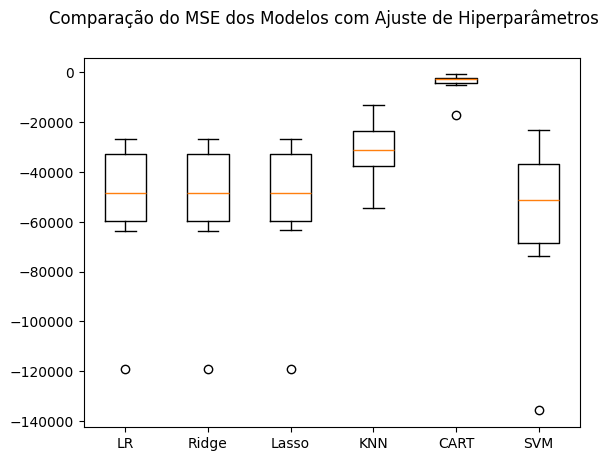

In [ ]:
# Lista de modelos com hiperparâmetros para ajuste
models = [
    ('LR', LinearRegression(), {}),
    ('Ridge', Ridge(), {'alpha': [0.1, 1.0, 10]}),
    ('Lasso', Lasso(), {'alpha': [0.01, 0.1, 1.0]}),
    ('KNN', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
    ('CART', DecisionTreeRegressor(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}),
    ('SVM', SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})
]

# Avaliação de cada modelo com ajuste de hiperparâmetros
results = []
names = []
best_params = {}

for name, model, params in models:
    if params:  # Se há hiperparâmetros para ajustar
        grid_search = GridSearchCV(model, param_grid=params, cv=kfold, scoring='neg_mean_squared_error')
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_
    else:  # Sem ajuste
        best_model = model.fit(x_train, y_train)

    # Validação cruzada com o melhor modelo
    cv_results = cross_val_score(best_model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)

    # Imprimindo os resultados (MSE e RMSE)
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (
        name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean()))
    )
    print(msg)

# Comparação visual dos resultados com um boxplot
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos com Ajuste de Hiperparâmetros')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



 Ao comparar os novos resultados com os anteriores, observa-se que o modelo CART manteve o melhor desempenho, mesmo não tendo apresentado uma melhoria após a execução com os hiperparâmetros. Por outro lado, o modelo KNN apresentou uma melhoria significativa no desempenho, reduzindo seu MSE e RMSE. Os modelos de Regressão Linear, Ridge e Lasso, apresentaram uma pequena variação nos valores de MSE e RMSE, sugerindo uma leve melhoria em relação à execução anterior. Já o modelo SVM ainda apresentou resultados elevados, mantendo sua posição como modelo com desempenho mais baixo.

Uma possibilidade para melhorar ainda mais o desempenho seria a consideração de métodos mais avançados ou complexos, como o Random Forest, um ensemble de árvores de decisão que reduz overfitting, ou o Gradient Boosting (XGBoost, LightGBM, CatBoost), que ajusta erros residuais de forma sequencial e apresenta um bom desempenho em problemas de regressão.

Outra abordagem seria criar um comitê de modelos, como um Voting Regressor, que combina previsões de diferentes regressões (Ridge, Lasso, Decision Trees), ou um Bagging Regressor, que treina múltiplos modelos independentes, reduzindo overfitting.


**Avaliação dos Resultados**

Foi utilizado o modelo de Árvore de Decisão (CART) para prever valores do conjunto de dados de teste. Em seguida, foi feita a avalição do modeco com o cálculo do Erro Quadrático Médio (MSE) e da Raiz do Erro Quadrático Médio (RMSE).

In [ ]:
# Definição do modelo CART (Árvore de Decisão)
model = DecisionTreeRegressor()

# Treinamento do modelo com os dados de treino
model.fit(x_train, y_train)

# Predições com o conjunto de teste
predictions = model.predict(x_test)

# Estimativa do MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))



MSE 1424.43
RMSE 37.74



Os resultados apresentados indicam que o modelo tem um bom desempenho nas previsões, com um erro médio relativamente baixo. O MSE e o RMSE sugerem que o modelo foi capaz de prever os valores com precisão razoáve. Não foi identificado um problema claro de overfitting, por mais que modelos de Árvore de Decisão, como o CART, têm uma tendência a se ajustar excessivamente aos dados de treinamento, o que pode prejudicar o desempenho quando o modelo é aplicado a novos dados.